<a href="https://colab.research.google.com/github/asia281/rl2023/blob/main/Asia_of_Lab_PPO_2023_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

!pip install gym[box2d,classic_control]
!pip install -U colabgymrender

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [2]:
from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [3]:
!wget https://raw.githubusercontent.com/awarelab/spinningup_tf2/main/spinup_bis/algos/tf2/vpg/core.py

--2023-04-03 19:24:45--  https://raw.githubusercontent.com/awarelab/spinningup_tf2/main/spinup_bis/algos/tf2/vpg/core.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6401 (6.3K) [text/plain]
Saving to: ‘core.py’

core.py             100%[===================>]   6.25K  --.-KB/s    in 0s      

2023-04-03 19:24:46 (48.2 MB/s) - ‘core.py’ saved [6401/6401]



# Logger

In [4]:
import os.path as osp
import os
import atexit
import numpy as np

class Logger:
    """A general-purpose logger.

    Makes it easy to save diagnostics, hyperparameter configurations, the
    state of a training run, and the trained model.
    """

    def __init__(self,
                 output_dir=None,
                 output_fname='progress.txt',
                 exp_name=None):
        """Initialize a Logger.

        Args:
            output_dir (string): A directory for saving results to. If
                ``None``, defaults to a temp directory of the form
                ``/tmp/experiments/somerandomnumber``.

            output_fname (string): Name for the tab-separated-value file
                containing metrics logged throughout a training run.
                Defaults to ``progress.txt``.

            exp_name (string): Experiment name. If you run multiple training
                runs and give them all the same ``exp_name``, the plotter
                will know to group them. (Use case: if you run the same
                hyperparameter configuration with multiple random seeds, you
                should give them all the same ``exp_name``.)

            neptune_kwargs (dict): Neptune init kwargs. If None, then Neptune
                logging is disabled.
        """
        self.output_dir = output_dir or '/tmp/experiments/%i' % int(
            time.time())
        if osp.exists(self.output_dir):
            print('Warning: Log dir %s already exists! '
                    'Storing info there anyway.' % self.output_dir)
        else:
            os.makedirs(self.output_dir)
        self.output_file = open(
            osp.join(self.output_dir, output_fname), 'w')
        atexit.register(self.output_file.close)
        print('Logging data to %s' %
                        self.output_file.name)

        self.first_row = True
        self.log_headers = []
        self.log_current_row = {}
        self.exp_name = exp_name

    def log(self, msg):
        """Print a colorized message to stdout."""
        print(msg)

    def log_tabular(self, key, val):
        """Log a value of some diagnostic.

        Call this only once for each diagnostic quantity, each iteration.
        After using ``log_tabular`` to store values for each diagnostic,
        make sure to call ``dump_tabular`` to write them out to file and
        stdout (otherwise they will not get saved anywhere).
        """
        if self.first_row:
            self.log_headers.append(key)
        else:
            assert key in self.log_headers, \
                'Trying to introduce a new key %s that ' \
                'you didn\'t include in the first iteration' % key
        assert key not in self.log_current_row, \
            'You already set %s this iteration. ' \
            'Maybe you forgot to call dump_tabular()' % key
        self.log_current_row[key] = val

    def dump_tabular(self):
        """Write all of the diagnostics from the current iteration.

        Writes both to stdout, and to the output file.
        """
        vals = []
        key_lens = [len(key) for key in self.log_headers]
        max_key_len = max(15, max(key_lens))
        keystr = '%' + '%d' % max_key_len
        fmt = '| ' + keystr + 's | %15s |'
        n_slashes = 22 + max_key_len
        print('-' * n_slashes)
        for key in self.log_headers:
            val = self.log_current_row.get(key, '')
            valstr = '%8.3g' % val if hasattr(val, '__float__') else val
            print(fmt % (key, valstr))
            vals.append(val)
        print('-' * n_slashes, flush=True)
        if self.output_file is not None:
            if self.first_row:
                self.output_file.write('\t'.join(self.log_headers) + '\n')
            self.output_file.write('\t'.join(map(str, vals)) + '\n')
            self.output_file.flush()
        self.log_current_row.clear()
        self.first_row = False


class EpochLogger(Logger):
    """A variant of Logger tailored for tracking average values over epochs.

    Typical use case: there is some quantity which is calculated many times
    throughout an epoch, and at the end of the epoch, you would like to
    report the average / std / min / max value of that quantity.

    With an EpochLogger, each time the quantity is calculated, you would
    use

    .. code-block:: python

        epoch_logger.store(NameOfQuantity=quantity_value)

    to load it into the EpochLogger's state. Then at the end of the epoch, you
    would use

    .. code-block:: python

        epoch_logger.log_tabular(NameOfQuantity, **options)

    to record the desired values.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_dict = dict()

    def store(self, **kwargs):
        """Save something into the epoch_logger's current state.

        Provide an arbitrary number of keyword arguments with numerical
        values.
        """
        for k, v in kwargs.items():
            if k not in self.epoch_dict.keys():
                self.epoch_dict[k] = []
            self.epoch_dict[k].append(v)

    def log_tabular(self,  # pylint: disable=arguments-differ
                    key,
                    val=None,
                    with_min_and_max=False,
                    average_only=False):
        """Log a value or possibly the mean/std/min/max values of a diagnostic.

        Args:
            key (string): The name of the diagnostic. If you are logging a
                diagnostic whose state has previously been saved with
                ``store``, the key here has to match the key you used there.

            val: A value for the diagnostic. If you have previously saved
                values for this key via ``store``, do *not* provide a ``val``
                here.

            with_min_and_max (bool): If true, log min and max values of the
                diagnostic over the epoch.

            average_only (bool): If true, do not log the standard deviation
                of the diagnostic over the epoch.
        """
        if val is not None:
            super().log_tabular(key, val)
        else:
            v = self.epoch_dict[key]
            vals = np.concatenate(v) if isinstance(
                v[0], np.ndarray) and len(v[0].shape) > 0 else v
            stats = np.mean(vals), np.std(vals), np.min(vals), np.max(vals)
            super().log_tabular(
                key if average_only else 'Average' + key, stats[0])
            if not average_only:
                super().log_tabular('Std' + key, stats[1])
            if with_min_and_max:
                super().log_tabular('Max' + key, stats[3])
                super().log_tabular('Min' + key, stats[2])
        self.epoch_dict[key] = []

# The Code of VPG & PPO

In [5]:
import abc
import random
import time

import numpy as np
import tensorflow as tf

import core


In [6]:
class Buffer:
    """A buffer for storing trajectories experienced by a VPG agent.

    Uses Generalized Advantage Estimation (GAE-Lambda) for calculating
    the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim),
                                dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim),
                                dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size  # buffer has to have room
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """Computes reward for unfinished trajectory.

        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.
        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = \
            core.discount_cumsum(deltas, self.gamma * self.lam)

        # the next line computes rewards-to-go, targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        """Returns data stored in buffer.

        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size  # buffer has to be full
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = self.adv_buf.mean(), self.adv_buf.std()
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        return [self.obs_buf, self.act_buf, self.adv_buf,
                self.ret_buf, self.logp_buf]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
class PolicyGradientAlgorithm(abc.ABC):
    def __init__(self, env_fn, actor_critic=core.mlp_actor_critic, ac_kwargs=None, seed=0,
            total_steps=int(1e6), train_every=4000, log_every=4000, gamma=0.99,
            pi_lr=3e-4, v_lr=1e-3, train_v_iters=80, lam=0.97, max_ep_len=1000,
            logger_kwargs=None):
        """Vanilla Policy Gradient with GAE-Lambda for advantage estimation.

        Args:
            env_fn : A function which creates a copy of the environment.
                The environment must satisfy the OpenAI Gym API.

            actor_critic: A function which takes in `action_space` and
                `observation_space` kwargs, and returns actor and critic
                tf.keras.Model-s.

            ac_kwargs (dict): Any kwargs appropriate for the actor_critic
                function you provided to VPG.

            seed (int): Seed for random number generators.

            total_steps (int): Number of environment interactions to run and train
                the agent.

            train_every (int): Number of environment interactions that should elapse
                between training epochs.

            log_every (int): Number of environment interactions that should elapse
                between dumping logs.

            gamma (float): Discount factor. (Always between 0 and 1.)

            pi_lr (float): Learning rate for policy optimizer.

            v_lr (float): Learning rate for value function optimizer.

            train_v_iters (int): Number of gradient descent steps to take on
                value function per epoch.

            lam (float): Lambda for GAE-Lambda. (Always between 0 and 1,
                close to 1.)

            max_ep_len (int): Maximum length of trajectory / episode / rollout.

            logger_kwargs (dict): Keyword args for EpochLogger.
        """
        params_to_save = locals()
        self.logger = EpochLogger(**(logger_kwargs or {}))

        random.seed(seed)
        tf.random.set_seed(seed)
        np.random.seed(seed)

        # In case of distributed computations these values have to be updated
        self.total_steps = total_steps
        self.train_every = train_every
        self.log_every = log_every
        self.max_ep_len = max_ep_len
        self.train_v_iters = train_v_iters

        self.env = env_fn()
        obs_dim = np.prod(self.env.observation_space.shape)
        act_dim = self.env.action_space.shape
        self.env.seed(seed)

        self.replay_buffer = Buffer(obs_dim=obs_dim, act_dim=act_dim,
                                size=train_every, gamma=gamma, lam=lam)

        ac_kwargs = ac_kwargs or {}
        ac_kwargs['observation_space'] = self.env.observation_space
        ac_kwargs['action_space'] = self.env.action_space

        self.actor, self.critic = actor_critic(**ac_kwargs)

        self.actor.build(input_shape=(None, obs_dim))
        self.critic.build(input_shape=(None, obs_dim))

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=pi_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=v_lr)

    @tf.function
    def value(self, observations):
        return self.critic(observations)

    def get_value(self, observation):
        return self.value(np.array([observation])).numpy()[0]

    @tf.function
    def value_loss(self, observations, rtg):
        return tf.reduce_mean((self.critic(observations) - rtg) ** 2)

    @tf.function
    def value_train_step(self, observations, rtg):
        def loss():
            return self.value_loss(observations, rtg)

        self.critic_optimizer.minimize(loss, self.critic.trainable_variables)

        return loss()

    def get_action(self, observation):
        return self.actor.action(np.array([observation])).numpy()[0]

    @tf.function
    def pi_train_step(self, observations, actions, advantages, logp_old):
        def loss():
            logp = self.actor.action_logprob(observations, actions)
            return self.pi_loss(logp, logp_old, advantages)

        self.actor_optimizer.minimize(loss, self.actor.trainable_variables)

        # For logging purposes
        logp = self.actor.action_logprob(observations, actions)
        loss_new = self.pi_loss(logp, logp_old, advantages)

        return loss_new, tf.reduce_mean(logp_old - logp), tf.reduce_mean(-logp)

    def run(self):
        start_time = time.time()
        obs, ep_ret, ep_len = self.env.reset(), 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for t in range(self.total_steps):
            action = self.get_action(obs)
            v_t = self.get_value(obs)
            logp = self.actor.action_logprob(np.array([obs]),
                                        np.array([action])).numpy()[0]

            # Step the env
            new_obs, rew, done, _ = self.env.step(action)
            ep_ret += rew
            ep_len += 1

            # Ignore the "done" signal if it comes from hitting the time
            # horizon (that is, when it's an artificial terminal signal
            # that isn't based on the agent's state)
            done = False if ep_len == self.max_ep_len else done

            # Store experience to replay buffer
            self.replay_buffer.store(obs, action, rew, v_t, logp)
            self.logger.store(VVals=v_t)

            # Super critical, easy to overlook step: make sure to update
            # most recent observation!
            obs = new_obs

            # End of trajectory handling
            if done or (ep_len == self.max_ep_len):
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)

            if done or (ep_len == self.max_ep_len) or (t + 1) % self.train_every == 0:
                obs, ep_ret, ep_len = self.env.reset(), 0, 0

                # if trajectory didn't reach terminal state, bootstrap value target
                last_val = 0 if done else self.get_value(obs)
                self.replay_buffer.finish_path(last_val)

            # Update handling
            if (t + 1) % self.train_every == 0:
                self.do_update()

            # End of epoch wrap-up
            if ((t + 1) % self.log_every == 0) or (t + 1 == self.total_steps):
                # Log info about epoch
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                self.logger.log_tabular('EpLen', average_only=True)
                self.logger.log_tabular('VVals', with_min_and_max=True)
                self.logger.log_tabular('LossV', average_only=True)
                self.logger.log_tabular('LossPi', average_only=True)
                self.logger.log_tabular('Entropy', average_only=True)
                self.logger.log_tabular('KL', average_only=True)
                self.logger.log_tabular('TotalEnvInteracts', (t + 1))
                self.logger.log_tabular('Time', time.time() - start_time)
                self.logger.dump_tabular()

    @abc.abstractmethod
    def do_update(self):
        pass


    @abc.abstractmethod
    def pi_loss(self, logp, advantages):
        pass

# Exercise
Please fill in missing pieces of code marked:
```
###### TODO ######
<Descritpion>
#-----------------

###### END  ######

```

In [8]:
class VPG(PolicyGradientAlgorithm):
    def do_update(self):
        [batch_obs, batch_act, batch_adv, batch_rtg,
        batch_logp] = self.replay_buffer.get()

        loss, kl, entropy = self.pi_train_step(batch_obs, batch_act,
                                        batch_adv, batch_logp)
        self.logger.store(LossPi=loss.numpy(), KL=kl.numpy(),
                    Entropy=entropy.numpy())

        for _ in range(self.train_v_iters):
            loss = self.value_train_step(batch_obs, batch_rtg)
            self.logger.store(LossV=loss)

    @tf.function
    def pi_loss(self, logp, _logp_old, advantages):
        ###### TODO ######
        # Implement pi loss calculation 
        #-----------------
        loss = -tf.reduce_mean(logp * advantages)
        ###### END  ######
        return loss


class PPO(PolicyGradientAlgorithm):
    def __init__(self, clip_ratio=0.2, train_pi_iters=80, target_kl=0.01, **kwargs):
        """Proximal Policy Optimization (by clipping).

        Args:
            clip_ratio : Hyperparameter for clipping in the policy objective.

            train_pi_iters: Maximum number of gradient descent steps to take
                on policy loss per epoch. (Early stopping may cause optimizer
                to take fewer than this.)

            target_kl (dict): Roughly what KL divergence we think is appropriate
                between new and old policies after an update. This will get used
                for early stopping.
        """
        super(PPO, self).__init__(**kwargs)
        self.clip_ratio = clip_ratio
        self.train_pi_iters = train_pi_iters
        self.target_kl = target_kl

    def do_update(self):
        [batch_obs, batch_act, batch_adv, batch_rtg,
            batch_logp] = self.replay_buffer.get()

        for i in range(self.train_pi_iters):
            loss, kl, entropy = self.pi_train_step(batch_obs, batch_act,
                                                batch_adv, batch_logp)
            self.logger.store(LossPi=loss.numpy(), KL=kl.numpy(),
                            Entropy=entropy.numpy())
            
            ###### TODO ######
            # Implement early stopping of pi training based on kl value
            # Log step at which you break the loop using self.logger.log method
            #-----------------
            if kl > self.target_kl:
                self.logger.log(f'Early stopping at step {i}.')
                break
            ###### END  ######

        for _ in range(self.train_v_iters):
            loss = self.value_train_step(batch_obs, batch_rtg)
            self.logger.store(LossV=loss)

    @tf.function
    def pi_loss(self, logp, logp_old, advantages):
        ###### TODO ######
        # Implement pi loss calcualation
        #-----------------
        p_ratio = tf.exp(logp - logp_old)
        clipped_advantage = tf.clip_by_value(p_ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
        loss = -tf.reduce_mean(tf.minimum(p_ratio * advantages, clipped_advantage * advantages))
        ###### END  ######
        return loss 

# Lets test the solution - train the agents

## First sanity check on CartPole
If your implementation cannot reach the goals specified below you might have some bug in your code.

In [9]:
import gym

from core import mlp_actor_critic

def env_fn():
    env = gym.make("CartPole-v1")
    return env

In [10]:
# VPG should reach performance over 100 with this setting 
vpg = VPG(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+4), v_lr=0.001, pi_lr=0.0003, train_every=500, max_ep_len=500, logger_kwargs={"output_dir": "./logs/vpg"})
vpg.run()

Logging data to ./logs/vpg/progress.txt


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------------
|      AverageEpRet |            30.6 |
|          StdEpRet |            16.8 |
|          MaxEpRet |              97 |
|          MinEpRet |               8 |
|             EpLen |            30.6 |
|      AverageVVals |            12.2 |
|          StdVVals |            6.23 |
|          MaxVVals |            19.8 |
|          MinVVals |           -5.07 |
|             LossV |             186 |
|            LossPi |         -0.0152 |
|           Entropy |           0.679 |
|                KL |        -4.1e-05 |
| TotalEnvInteracts |           4e+03 |
|              Time |            35.8 |
---------------------------------------
---------------------------------------
|      AverageEpRet |            35.6 |
|          StdEpRet |            21.1 |
|          MaxEpRet |             128 |
|          MinEpRet |              10 |
|             EpLen |            35.6 |
|      AverageVVals |            20.3 |
|          StdVVals |            4.59 |


In [11]:
# PPO should reach performance around 500 with this setting
ppo = PPO(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+4), v_lr=0.001, pi_lr=0.0003, train_every=500, max_ep_len=500, logger_kwargs={"output_dir": "./logs/ppo"})
ppo.run()

Logging data to ./logs/ppo/progress.txt
Early stopping at step 9.
Early stopping at step 14.
Early stopping at step 16.
Early stopping at step 28.
Early stopping at step 43.
Early stopping at step 16.
---------------------------------------
|      AverageEpRet |            49.3 |
|          StdEpRet |              38 |
|          MaxEpRet |             179 |
|          MinEpRet |               8 |
|             EpLen |            49.3 |
|      AverageVVals |            15.5 |
|          StdVVals |            10.1 |
|          MaxVVals |            30.6 |
|          MinVVals |           -22.9 |
|             LossV |             454 |
|            LossPi |        -0.00951 |
|           Entropy |           0.631 |
|                KL |         0.00444 |
| TotalEnvInteracts |           4e+03 |
|              Time |            21.5 |
---------------------------------------
Early stopping at step 4.
Early stopping at step 41.
Early stopping at step 71.
Early stopping at step 5.
Early stoppin

## Now lets learn more difficult task

In [12]:
def env_fn():
    env = gym.make("BipedalWalker-v3")
    return env

In [20]:
vpg = VPG(env_fn=env_fn, actor_critic=mlp_actor_critic, total_steps=int(5e+5), v_lr=0.001, pi_lr=0.0003, train_every=1000, logger_kwargs={"output_dir": "./logs/vpg"})
vpg.run()

Logging data to ./logs/vpg/progress.txt


---------------------------------------
|      AverageEpRet |           -81.2 |
|          StdEpRet |            23.1 |
|          MaxEpRet |           -66.8 |
|          MinEpRet |            -121 |
|             EpLen |             774 |
|      AverageVVals |            -5.4 |
|          StdVVals |            3.38 |
|          MaxVVals |           0.625 |
|          MinVVals |           -8.88 |
|             LossV |             118 |
|            LossPi |          0.0239 |
|           Entropy |            3.69 |
|                KL |         0.00568 |
| TotalEnvInteracts |           4e+03 |
|              Time |            18.6 |
---------------------------------------
---------------------------------------
|      AverageEpRet |           -68.2 |
|          StdEpRet |            20.5 |
|          MaxEpRet |           -54.1 |
|          MinEpRet |            -104 |
|             EpLen |             795 |
|      AverageVVals |            -8.1 |
|          StdVVals |             2.4 |


In [19]:
ppo = PPO(env_fn=env_fn, actor_critic=mlp_actor_critic,  total_steps=int(5e+5), v_lr=0.001, pi_lr=0.0003, train_every=1000, logger_kwargs={"output_dir": "./logs/ppo"})
ppo.run()

Logging data to ./logs/ppo/progress.txt


/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Early stopping at step 1.
Early stopping at step 2.
Early stopping at step 2.
Early stopping at step 1.
---------------------------------------
|      AverageEpRet |           -90.8 |
|          StdEpRet |            25.5 |
|          MaxEpRet |           -60.9 |
|          MinEpRet |            -121 |
|             EpLen |             542 |
|      AverageVVals |           -5.36 |
|          StdVVals |            3.37 |
|          MaxVVals |           0.625 |
|          MinVVals |           -8.88 |
|             LossV |             202 |
|            LossPi |        -0.00711 |
|           Entropy |            3.69 |
|                KL |         0.00895 |
| TotalEnvInteracts |           4e+03 |
|              Time |              25 |
---------------------------------------
Early stopping at step 11.
Early stopping at step 2.
Early stopping at step 2.
---------------------------------------
|      AverageEpRet |           -55.7 |
|          StdEpRet |            3.05 |
|          MaxEpR

# Visualize learned policy

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [24]:
def test_agent(actor, movie_prefix="gymvideo"):
    NUM_TEST_RUNS = 10
    env = gym.make("BipedalWalker-v3")

    performance = []
    for _ in range(NUM_TEST_RUNS):
        done = False
        obs = env.reset()
        ep_reward = 0
        while not done:
            action = actor(tf.expand_dims(obs, axis=0))[0]
            obs, reward, done, info = env.step(action.numpy()[0])
            ep_reward += reward
        performance.append(ep_reward)

    env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env, "./", name_prefix=movie_prefix)
    obs = env.reset()
    while True:
        action = actor(tf.expand_dims(obs, axis=0))[0]
        obs, reward, done, info = env.step(action.numpy()[0])

        if done:
            break

    return np.asarray(performance)

In [25]:
vpg_performance = test_agent(vpg.actor, "vpg")
file_name = glob.glob('vpg*.mp4')[0]
show_video(file_name)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [26]:
ppo_performance = test_agent(ppo.actor, "ppo")
file_name = glob.glob('ppo*.mp4')[0]
show_video(file_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wra

# Evaluate performance

In [21]:
vpg_data = pd.read_csv("./logs/vpg/progress.txt", delimiter="\t")
ppo_data = pd.read_csv("./logs/ppo/progress.txt", delimiter="\t")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


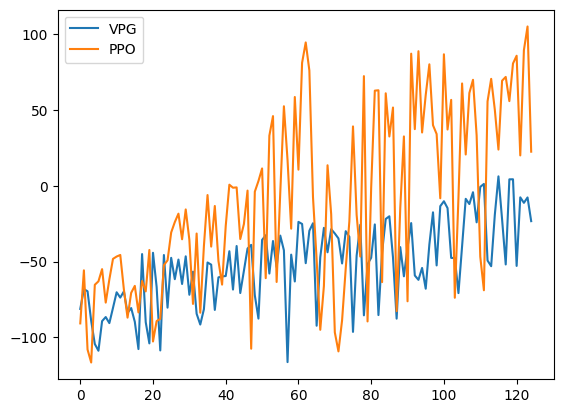

In [22]:
plt.plot(vpg_data["AverageEpRet"], label="VPG")
plt.plot(ppo_data["AverageEpRet"], label="PPO")
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 2 artists>

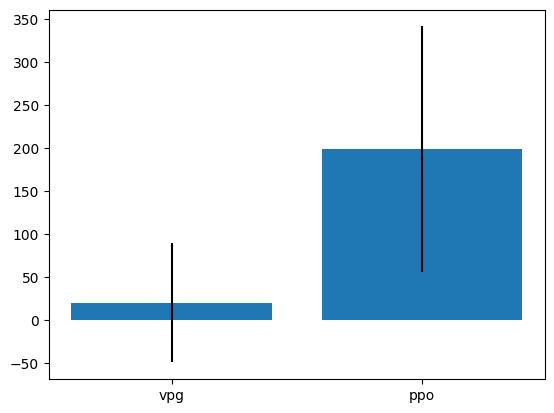

In [27]:
plt.bar(["vpg", "ppo"], [vpg_performance.mean(), ppo_performance.mean()], yerr=[vpg_performance.std(), ppo_performance.std()])